### 异常检测模型
#### isolationForest

### uncleaned

In [56]:
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.preprocessing import StandardScaler
train_df = pd.read_csv('../uncleaned_imbalanced_train_dataset.csv')
test_df = pd.read_csv('../uncleaned_test_dataset.csv')
# train_df = pd.read_csv('after_balanced_train_dataset.csv')
# test_df = pd.read_csv('after_balanced_test_dataset.csv')
# train_df = pd.read_csv('../uncleaned_balanced_train_dataset.csv')
# test_df = pd.read_csv('../uncleaned_test_dataset.csv')

X_train = train_df.drop('isFraud', axis=1)
y_train = train_df['isFraud']
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = IsolationForest(random_state=42) 
model.fit(X_train, y_train)

pred = model.predict(X_test)

pred[pred == 1] = 0
pred[pred == -1] = 1

print(pred)

[1 0 1 ... 0 0 1]


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np

# 数据加载
train_df = pd.read_csv('../uncleaned_imbalanced_train_dataset.csv')
test_df = pd.read_csv('../uncleaned_test_dataset.csv')

# 只选择非欺诈交易数据进行训练
X_train_normal = train_df[train_df['isFraud'] == 0].drop('isFraud', axis=1)

# 测试数据
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# 使用 IsolationForest
model = IsolationForest(
    contamination=0.05,  # 使用实际欺诈率
    n_estimators=300,
    max_samples=256,
    random_state=42
)

# 只用正常样本训练
model.fit(X_train_scaled)

# 预测
pred = model.predict(X_test_scaled)

# 转换标签：1(正常) -> 0, -1(异常) -> 1
pred= np.where(pred == 1, 0, 1)

In [2]:
from joblib import dump, load

# 保存模型
dump(model, 'fraud_detection_isolationforest.joblib')

['fraud_detection_isolationforest.joblib']


Confusion Matrix:
[[1207596   63285]
 [    743     900]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.01      0.55      0.03      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.75      0.50   1272524
weighted avg       1.00      0.95      0.97   1272524



C:\Users\lizey\PycharmProjects\MLTFproject\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


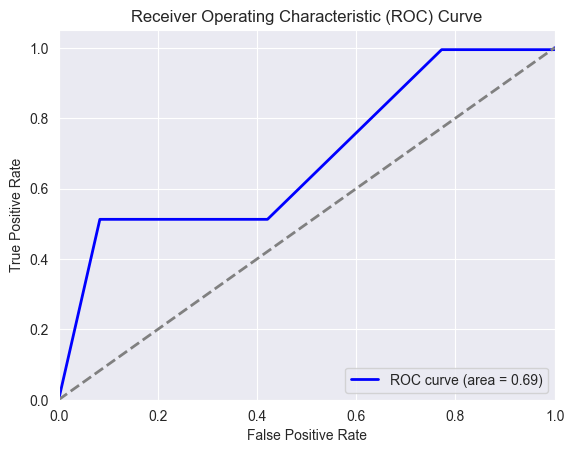

AUC-ROC Score: 0.6856508150068011


<Figure size 640x480 with 0 Axes>

In [59]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 混淆矩阵
cm = confusion_matrix(y_test, pred)
print("\nConfusion Matrix:")
print(cm)

# 2. 分类报告
cr = classification_report(y_test, pred)
print("\nClassification Report:")
print(cr)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 获取模型的决策函数分数
y_scores = -model.score_samples(X_test)  # 使用负分数，因为异常值应该有更高的分数

# 计算ROC曲线的参数
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.savefig('balanced_isolation_forest.png')

# 打印AUC分数
print(f"AUC-ROC Score: {roc_auc}")

### One class SVM

In [ ]:
from sklearn.svm import OneClassSVM
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 读取数据
train_df = pd.read_csv('../uncleaned_imbalanced_train_dataset.csv')
test_df = pd.read_csv('../uncleaned_test_dataset.csv')

X_train = train_df.drop('isFraud', axis=1)
y_train = train_df['isFraud']
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建和训练One-Class SVM模型
# nu参数是异常值的预期比例的上界，kernel可以选择'rbf'，'linear'或'poly'
model = OneClassSVM(kernel='rbf', nu=0.1)
model.fit(X_train_scaled)

# 预测
# One-Class SVM返回1表示正常，-1表示异常
pred = model.predict(X_test_scaled)

# 转换预测结果：-1(异常)转为1(欺诈)，1(正常)转为0(非欺诈)
pred[pred == 1] = 0
pred[pred == -1] = 1

In [ ]:

# 获取决策函数分数用于ROC曲线
y_scores = -model.decision_function(X_test_scaled)  # 使用负分数

# 计算并绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-Class SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 打印预测结果和AUC分数
print("Predictions:", pred)
print(f"AUC-ROC Score: {roc_auc:.4f}")

In [64]:
from sklearn.linear_model import SGDOneClassSVM

from sklearn.svm import OneClassSVM
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 读取数据
train_df = pd.read_csv('../uncleaned_imbalanced_train_dataset.csv')
test_df = pd.read_csv('../uncleaned_test_dataset.csv')
# train_df = pd.read_csv('../after_balanced_train_dataset.csv')
# test_df = pd.read_csv('../after_balanced_test_dataset.csv')

X_train = train_df.drop('isFraud', axis=1)
y_train = train_df['isFraud']
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = SGDOneClassSVM(
    random_state=42,
    max_iter=1000,      
    tol=1e-4
)
model.fit(X_train_scaled)

# 预测
# One-Class SVM返回1表示正常，-1表示异常
pred = model.predict(X_test_scaled)

# 转换预测结果：-1(异常)转为1(欺诈)，1(正常)转为0(非欺诈)
pred[pred == 1] = 0
pred[pred == -1] = 1



Confusion Matrix:
[[674404 596477]
 [   619   1024]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69   1270881
           1       0.00      0.62      0.00      1643

    accuracy                           0.53   1272524
   macro avg       0.50      0.58      0.35   1272524
weighted avg       1.00      0.53      0.69   1272524



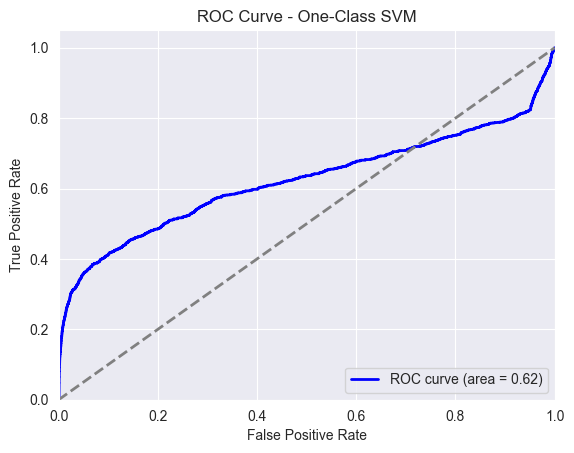

Predictions: [1 0 0 ... 0 1 1]
AUC-ROC Score: 0.6216


In [65]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, pred)
print("\nConfusion Matrix:")
print(cm)

# 2. 分类报告
cr = classification_report(y_test, pred)
print("\nClassification Report:")
print(cr)

# 获取决策函数分数用于ROC曲线
y_scores = -model.decision_function(X_test_scaled)  # 使用负分数

# 计算并绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-Class SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 打印预测结果和AUC分数
print("Predictions:", pred)
print(f"AUC-ROC Score: {roc_auc:.4f}")

ModuleNotFoundError: No module named 'cupy'

In [ ]:
pred[pred == 1] = 0
pred[pred == -1] = 1

# 获取决策函数分数用于ROC曲线
y_scores = -model.decision_function(X_test_scaled)  # 使用负分数

# 计算并绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-Class SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 打印预测结果和AUC分数
print("Predictions:", pred)
print(f"AUC-ROC Score: {roc_auc:.4f}")

In [3]:
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# 读取数据
print("正在读取数据...")
train_df = pd.read_csv('uncleaned_imbalanced_train_dataset.csv')
test_df = pd.read_csv('uncleaned_test_dataset.csv')

X_train = train_df.drop('isFraud', axis=1)
y_train = train_df['isFraud']
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

# 标准化数据
print("正在标准化数据...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建和训练LOF模型
print("开始训练LOF模型...")
model = LocalOutlierFactor(
    n_neighbors=20,        # 用于计算局部密度的邻居数
    contamination=0.1,     # 预期的异常比例
    n_jobs=-1,            # 使用所有CPU核心
    novelty=True          # 设置为True以便能用于预测新数据
)

# 训练模型
model.fit(X_train_scaled)

# 预测
print("正在进行预测...")
# LOF的predict方法返回1表示正常，-1表示异常
pred = model.predict(X_test_scaled)

# 转换预测结果：-1(异常)转为1(欺诈)，1(正常)转为0(非欺诈)
pred[pred == 1] = 0
pred[pred == -1] = 1

# 获取异常分数用于ROC曲线
# 对于LOF，我们使用negative_outlier_factor_
print("计算ROC曲线...")
y_scores = -model.score_samples(X_test_scaled)  # 使用负分数，使得异常值获得更高的分数

# 计算并绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Local Outlier Factor (LOF)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 打印评估指标
from sklearn.metrics import classification_report, confusion_matrix

print("\n分类报告:")
print(classification_report(y_test, pred))

print("\n混淆矩阵:")
print(confusion_matrix(y_test, pred))

print(f"\nAUC-ROC Score: {roc_auc:.4f}")

正在读取数据...
正在标准化数据...
开始训练LOF模型...


KeyboardInterrupt: 

FileNotFoundError: Please build the library first!